# <font color = green> Deloitte March Data Crunch Madness 2021

## <font color = black> Team: Alpha Titans
Members: Kolade Ladapo, Urvesh Bhadani, Ziqi Wang 

<img  
src="https://www.fordham.edu/images/gsb_ms_programs.jpg" style="width:400px;height:250px">

### <font color = grey> The following notebook is a model for determining winners of various matchups in the 2021 NCAA Mens March Madness Basketball Tournament
    

## <font color = green> Logistic Regression Model:

In [2]:
######################################################################
#importing required python packages to build logistic regression model
######################################################################

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [3]:
################################################################################
# defining a user function for distance calculations based on latitude/longitude
################################################################################

def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [4]:
###########################################
# Importing & Assigning dataset to variable
###########################################

mm_data = pd.read_csv('NCAA_Tourney_2002_2019_update.csv')

#####################
# Checking data shape
#####################
print("The shape of the dataset is as follows: ",'\n', mm_data.shape)

#############################
# Checking for missing values
#############################
print('\n',"Summary of missing values by predictor column: ",'\n', mm_data.isnull().sum())

The shape of the dataset is as follows:  
 (1167, 104)

 Summary of missing values by predictor column:  
 team1_id       0
team1_score    0
team2_id       0
team2_score    0
WLoc           0
              ..
team2_oe       0
team2_adjoe    0
team2_de       0
team2_adjde    0
game_id        0
Length: 104, dtype: int64


In [5]:
#########################################
# Assigning column names to an empty list
#########################################
mm_data.columns.tolist()

['team1_id',
 'team1_score',
 'team2_id',
 'team2_score',
 'WLoc',
 'num_ot',
 'team1_position',
 'team2_position',
 'team1_seed',
 'team2_seed',
 'strongseed',
 'weakseed',
 'team1_region',
 'team2_region',
 'slot',
 'team1_teamname',
 'team2_teamname',
 'season',
 'host',
 'host_lat',
 'host_long',
 'team1_lat',
 'team1_long',
 'team2_lat',
 'team2_long',
 'team1_coach_id',
 'team1_pt_school_ncaa',
 'team1_pt_overall_ncaa',
 'team1_pt_school_s16',
 'team1_pt_overall_s16',
 'team1_pt_school_ff',
 'team1_pt_overall_ff',
 'team1_pt_career_school_wins',
 'team1_pt_career_school_losses',
 'team1_pt_career_overall_wins',
 'team1_pt_career_overall_losses',
 'team1_pt_team_season_wins',
 'team1_pt_team_season_losses',
 'team1_pt_coach_season_wins',
 'team1_pt_coach_season_losses',
 'team2_coach_id',
 'team2_pt_school_ncaa',
 'team2_pt_overall_ncaa',
 'team2_pt_school_s16',
 'team2_pt_overall_s16',
 'team2_pt_school_ff',
 'team2_pt_overall_ff',
 'team2_pt_career_school_wins',
 'team2_pt_caree

### <font color = teal> Team Distance Calculation:

In [6]:
########################################################################
# Calculating team distance (during the match) from team's home location
########################################################################

#Determining distance, by assigning lat/long of location 1 to "distance 1"
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)

#Determining distance, by assigning lat/long of location 2 to "distance 2"
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

#Calculating distance between locations & assinging to variable
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']

### <font color = teal> Pythagorean Expectation Calculation:

#### <font color = grey> Pythagorean Expectation uses a team's points scored and points allowed to estimate how many games the team should have won and lost to date. Effectively, and estimate of where a team's win percantage should be based on points (scored/allowed) alone.  
    
    E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5

In [7]:
####################################################################################
# Calculating expected win percantage of each team using Pythag expectation equation
# Uses offensive efficiency (adjoe) and defensive efficiency (adjde) which is points
# scored or allowed per 100 possesions against an average defense/offense
####################################################################################

#Assigning expected win percantage per team to variables
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

### <font color = teal> Log 5 Calculation:

#### <font color = grey> The Log 5 formula was invented by Bill James to estimate the probability that team A will win a game. The equation is based on the true winning percentage of Team A and Team B. 
    
    P(W) = (A - A B) / (A + B - 2A*B)

In [8]:
#####################################################################################
# Using above calulated true win percantage of each team (assigned to exp_win1(2)) to 
# calculate team Log 5 value
#####################################################################################

mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [9]:
###############################################################################
# Viewing head preview of dataset (with relevant columns) to display calculated
# team_1 Log 5 values
###############################################################################

#Viewing top 10 rows
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head(10)

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,106.296,F Dickinson,2019,Prairie View,110.5500,0.389061,0.382990,0.506403
1,114.952,Belmont,2019,Temple,101.8860,0.800207,0.738939,0.585922
2,106.675,N Dakota St,2019,NC Central,109.8730,0.415885,0.208404,0.730051
3,109.886,Arizona St,2019,St John's,98.6844,0.774944,0.721882,0.570190
4,110.803,Minnesota,2019,Louisville,96.3335,0.833312,0.913200,0.322116
5,118.620,LSU,2019,Yale,97.6208,0.903836,0.709816,0.793493
6,119.283,Auburn,2019,New Mexico St,97.1706,0.913556,0.814356,0.706674
7,117.095,Villanova,2019,St Mary's CA,98.3195,0.881820,0.873304,0.519810
8,110.318,Florida,2019,Nevada,91.9997,0.889750,0.889494,0.500651
9,118.483,Wofford,2019,Seton Hall,97.7629,0.901196,0.808811,0.683148


### <font color = teal> Team Tournament Seeding Difference Calculation:

#### <font color = grey> Each Team in the tournament is assigned a seed (1-16) based on performance expectations in the tournament. The lower the seed, the greated expected level of success. Thus deterimining difference is seed value is pertinent to predicting matchup results. 

In [10]:
############################################
# Assigning & calculating difference in seed
############################################

mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [11]:
#################################################################################
#Displaying another head of relevant data to include previous matchup team scores 
#& newly calculated seeding difference
#################################################################################
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,seed_diff
0,2019-1192.0-1341.0,0.389061,0.382990,76,82,-648.033425,0.506403,1192.0,1341.0,0
1,2019-1125.0-1396.0,0.800207,0.738939,70,81,-307.876634,0.585922,1125.0,1396.0,0
2,2019-1295.0-1300.0,0.415885,0.208404,74,78,663.316546,0.730051,1295.0,1300.0,0
3,2019-1113.0-1385.0,0.774944,0.721882,65,74,1676.167033,0.570190,1113.0,1385.0,0
4,2019-1278.0-1257.0,0.833312,0.913200,76,86,-391.001293,0.322116,1278.0,1257.0,3


### <font color = teal> Team Season Win Difference Calculation: 

#### <font color = grey> Tournmaent seeding often accounts for how successful a team's season performance was. However, even teams with the same or similar seeding may have a significant difference in their number of season wins. Thus season wins may still be a relevant predictor. 

In [12]:
#############################################################
# Assigning & calculating difference in number of season wins
#############################################################

mm_data['team_win_diff'] = mm_data['team1_pt_team_season_wins'] - mm_data['team2_pt_team_season_wins']

In [13]:
#################################################################################
#Displaying another head of relevant data to include previous matchup team scores 
# seeding difference & newly calculated team win difference
#################################################################################
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff', 'team_win_diff']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,seed_diff,team_win_diff
0,2019-1192.0-1341.0,0.389061,0.382990,76,82,-648.033425,0.506403,1192.0,1341.0,0,-1.0
1,2019-1125.0-1396.0,0.800207,0.738939,70,81,-307.876634,0.585922,1125.0,1396.0,0,4.0
2,2019-1295.0-1300.0,0.415885,0.208404,74,78,663.316546,0.730051,1295.0,1300.0,0,1.0
3,2019-1113.0-1385.0,0.774944,0.721882,65,74,1676.167033,0.570190,1113.0,1385.0,0,2.0
4,2019-1278.0-1257.0,0.833312,0.913200,76,86,-391.001293,0.322116,1278.0,1257.0,3,1.0


### <font color = teal> Coach Career Wins at Current School Difference Calculation: 

#### <font color = grey> Tournmaent seeding often accounts for how successful a team's season performance was. However, even teams with the same or similar seeding may have a significant difference in their number of season wins. Thus season wins may still be a relevant predictor. 

In [44]:
###################################################################
# Assigning & calculating difference in coach career wins with team
###################################################################

mm_data['coach_win_diff'] = mm_data['team1_pt_career_school_wins'] - mm_data['team2_pt_career_school_wins']

In [45]:
#################################################################################
#Displaying another head of relevant data to include previous matchup team scores 
# seeding difference,team win difference, & newly calculated coach win difference
#################################################################################
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id','seed_diff', 'team_win_diff', 'coach_win_diff']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id,seed_diff,team_win_diff,coach_win_diff
0,2019-1192.0-1341.0,0.389061,0.382990,76,82,-648.033425,0.506403,1192.0,1341.0,0,1.0,24.0
1,2019-1125.0-1396.0,0.800207,0.738939,70,81,-307.876634,0.585922,1125.0,1396.0,0,-4.0,145.0
2,2019-1295.0-1300.0,0.415885,0.208404,74,78,663.316546,0.730051,1295.0,1300.0,0,-1.0,-93.0
3,2019-1113.0-1385.0,0.774944,0.721882,65,74,1676.167033,0.570190,1113.0,1385.0,0,-2.0,14.0
4,2019-1278.0-1257.0,0.833312,0.913200,76,86,-391.001293,0.322116,1278.0,1257.0,-3,-1.0,91.0


### <font color = green> Splitting the dataset for subsequent model training:

In [92]:
#########################
# Dropping missing values
#########################
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [93]:
###############################################
# Assigning & determing if team 1 won the match
###############################################
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [94]:
###############################################
# Creating user defined function to randomly 
# shuffle the dataset, creating random matchups
###############################################

np.random.seed(0)

def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
random_indices = random.sample(range(len(mm_data)), int(len(mm_data)/2))

In [95]:
# new dataframe creation based on relevant predictors
mm_data_1 = mm_data[~mm_data.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                                      'team1_score','team1_log5','team1_id','team2_id','seed_diff','team_win_diff', 'coach_win_diff']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(random_indices)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','team1_log5','team1_id','team2_id','seed_diff','team_win_diff', 'coach_win_diff']].reset_index(drop=True)

In [96]:
# new dataframe & variable assignment
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
mm_data['team_win_diff'] = mm_data['team_win_diff']*-1
mm_data['coach_win_diff'] = mm_data['coach_win_diff']*-1
mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','team_win_diff', 'coach_win_diff']

In [97]:
# combining results from dataframe 1 and dataframe 2 into one training data frame
mm_train = pd.concat([mm_data_2, mm_data_1])

In [98]:
mm_data_2019 = mm_train[mm_train['season'] == 2019].reset_index(drop=True)
mm_data_else =  mm_train[mm_train['season'] != 2019].reset_index(drop=True)

### <font color = teal> Intial Calculation Checks:

In [99]:
# Log 5 check
mm_data_else.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.386815
1    0.627296
Name: team1_log5, dtype: float64

In [100]:
# Seed differential check
mm_data_else.groupby('team1_win')['seed_diff'].mean()

team1_win
0    3.537071
1    3.817185
Name: seed_diff, dtype: float64

In [60]:
# Distance differential check
# mm_data_else.groupby('team1_win')['diff_dist'].mean()

### <font color = teal> Logistic Regression Model Training:

In [101]:
scaler = StandardScaler()
mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','seed_diff','team_win_diff', 'coach_win_diff']])
logit = LogisticRegression()
logit.fit(mm_train_scaled, mm_data_else['team1_win'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else[['team1_log5','seed_diff','team_win_diff', 'coach_win_diff']]).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.665983
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1100
Model:                          Logit   Df Residuals:                     1096
Method:                           MLE   Df Model:                            3
Date:                Tue, 23 Feb 2021   Pseudo R-squ.:                 0.03917
Time:                        16:51:08   Log-Likelihood:                -732.58
converged:                       True   LL-Null:                       -762.45
Covariance Type:            nonrobust   LLR p-value:                 6.721e-13
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
team1_log5         0.9307      0.127      7.323      0.000       0.682       1.180
seed_diff         -0.0311      0.010     -3.155      0.002      -0.050      -0.012
team_win_diff     -0.0008      0.001     -0.642      0.521      -0.003       0.002
coach_win_diff     0.0003      0.000      1.156      0.248      -0.000       0.001
==================================================================================
"""

In [103]:
mm_data_2019['prob'] = logit.predict_proba(scaler.fit_transform(mm_data_2019[['team1_log5','seed_diff','team_win_diff', 'coach_win_diff']]))[:,1]
mm_data_2019['prediction'] = logit.predict(scaler.fit_transform(mm_data_2019[['team1_log5','seed_diff','team_win_diff','coach_win_diff']]))

In [104]:
mm_data_2019[['team1_log5','team1_win','prob','prediction']].head(10)

,team1_log5,team1_win,prob,prediction
0,0.493597,0,0.472781,0
1,0.414078,0,0.401501,0
2,0.269949,0,0.235250,0
3,0.677884,0,0.688065,1
4,0.480190,0,0.477456,0
5,0.499349,0,0.444961,0
6,0.198387,0,0.202425,0
7,0.169262,0,0.174391,0
8,0.046460,0,0.110129,0
9,0.031185,0,0.119071,0


In [105]:
mm_data_2019.groupby('team1_win')['prob'].mean()

team1_win
0    0.318946
1    0.638093
Name: prob, dtype: float64

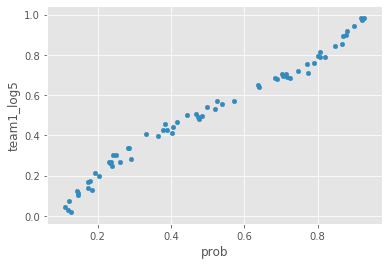

In [106]:
mm_data_2019.plot(kind='scatter', x='prob',y='team1_log5')

In [107]:
confusion_matrix(mm_data_2019['team1_win'], mm_data_2019['prediction'])

array([[25,  5],
       [12, 25]], dtype=int64)

In [108]:
accuracy_score(mm_data_2019['team1_win'], mm_data_2019['prediction'],)

0.746268656716418

In [109]:
precision_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.8333333333333334

In [110]:
recall_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.6756756756756757

In [111]:
f1_score(mm_data_2019['team1_win'], mm_data_2019['prediction'])

0.746268656716418

In [112]:
log_loss(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.4887038071323596

In [113]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

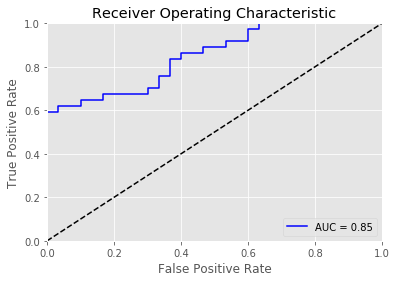

In [114]:
fpr, tpr, thresholds = roc_curve(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [115]:
roc_auc_score(mm_data_2019['team1_win'].values, mm_data_2019['prob'].values)

0.8486486486486486

### <font color = green> Creating Submission File: 

In [39]:
mm_data_2019[['game_id','prob']].head()

,game_id,prob
0,2019-1125.0-1396.0,0.389448
1,2019-1295.0-1300.0,0.264693
2,2019-1437.0-1388.0,0.408716
3,2019-1196.0-1305.0,0.483820
4,2019-1242.0-1318.0,0.161476


In [40]:
mm_data_2019['prob'] = .5

In [41]:
mm_data_2019[['game_id','prob']].to_csv("example_submission.csv", index=False)